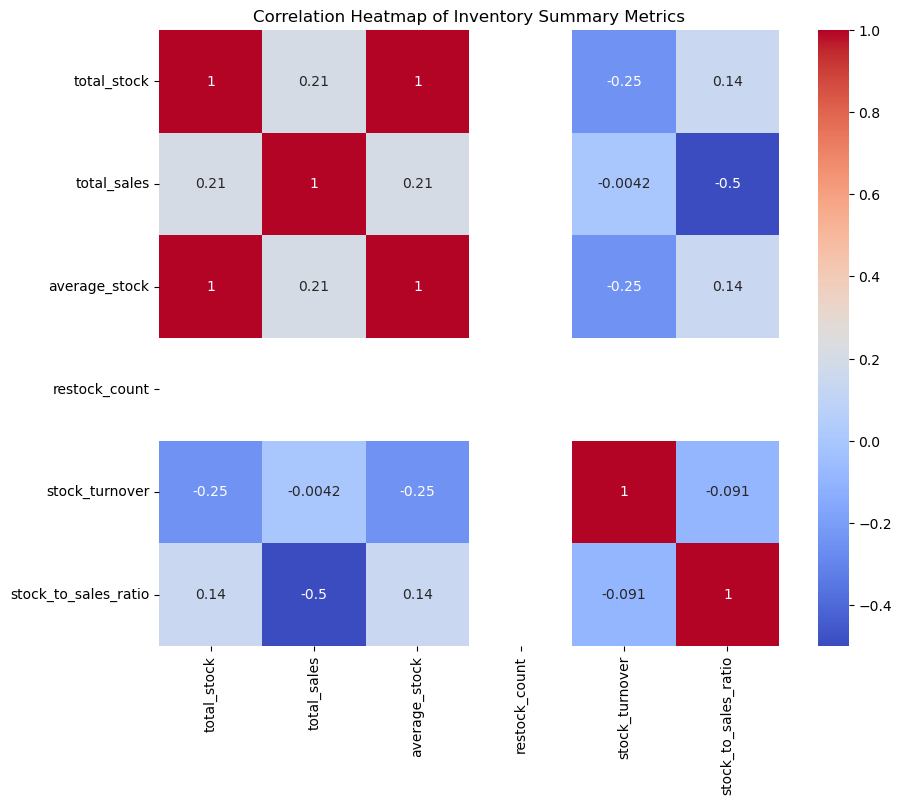

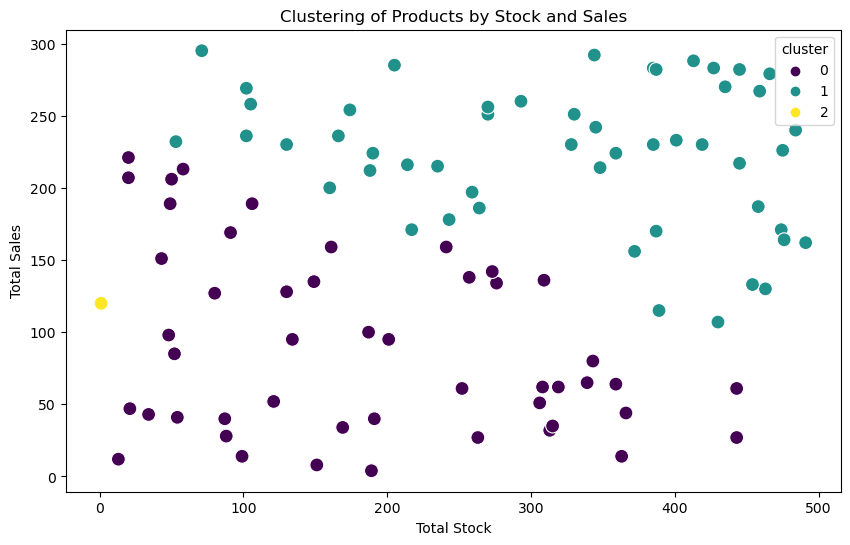

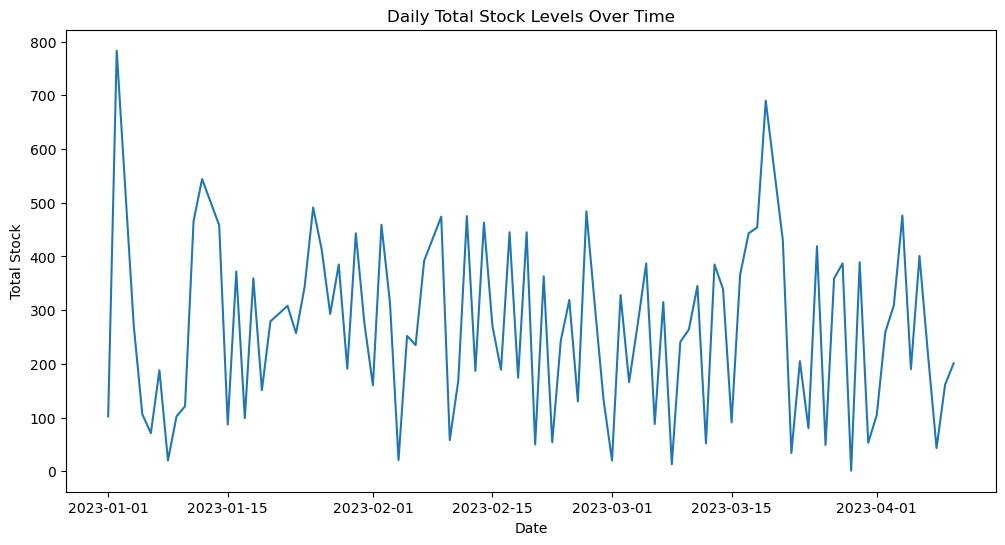

C:\Users\JAI\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


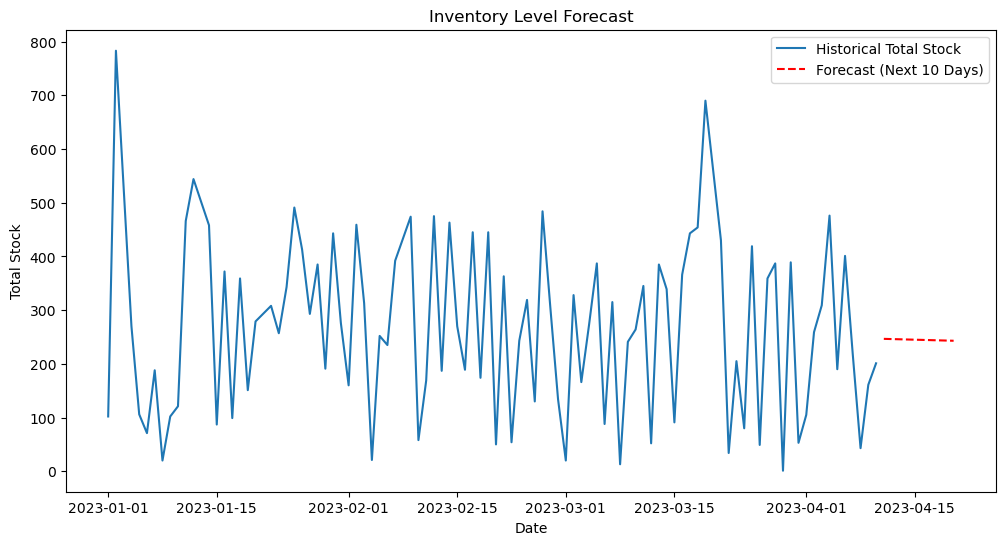

Inventory Summary (first 5 rows):
   product_id  total_stock  total_sales last_restock  average_stock  \
0           1          102          269   2023-01-01          102.0   
1           2          435          270   2023-01-02          435.0   
2           3          348          214   2023-01-02          348.0   
3           4          270          251   2023-01-04          270.0   
4           5          106          189   2023-01-05          106.0   

   restock_count  stock_turnover  stock_to_sales_ratio  cluster  
0              1        2.637255              0.379182        1  
1              1        0.620690              1.611111        1  
2              1        0.614943              1.626168        1  
3              1        0.929630              1.075697        1  
4              1        1.783019              0.560847        0  

Slow-Moving Products (first 5 rows):
    product_id  total_stock  total_sales last_restock  average_stock  \
9           10          121      

In [1]:
# Required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Additional libraries for advanced analysis
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression
import datetime

# Load the dataset
inventory_data = pd.read_csv("inventory_data.csv")

# Handling Missing Values
inventory_data['restock_date'] = pd.to_datetime(inventory_data['restock_date'])
inventory_data['restock_date'].fillna(method='ffill', inplace=True)

# Data Aggregation: Inventory per product
inventory_summary = inventory_data.groupby('product_id').agg(
    total_stock=('stock_level', 'sum'),
    total_sales=('sales', 'sum'),
    last_restock=('restock_date', 'max'),
    average_stock=('stock_level', 'mean'),
    restock_count=('restock_date', 'count')
).reset_index()

# Stock Turnover Calculation: Sales per unit of stock
inventory_summary['stock_turnover'] = inventory_summary['total_sales'] / inventory_summary['total_stock'].replace(0, np.nan)

# Additional KPI: Stock-to-Sales Ratio
inventory_summary['stock_to_sales_ratio'] = inventory_summary['total_stock'] / inventory_summary['total_sales'].replace(0, np.nan)

# Identify Slow-Moving and High-Demand Products
slow_moving = inventory_summary[inventory_summary['stock_turnover'] < 0.5]
high_demand = inventory_summary[inventory_summary['stock_turnover'] > 2]

# Outlier Detection (Excess Inventory) using IQR
q1 = inventory_summary['total_stock'].quantile(0.25)
q3 = inventory_summary['total_stock'].quantile(0.75)
iqr = q3 - q1
outliers = inventory_summary[
    (inventory_summary['total_stock'] < (q1 - 1.5 * iqr)) | 
    (inventory_summary['total_stock'] > (q3 + 1.5 * iqr))
]

# ----- Advanced Insights and Analysis -----

# 1. Correlation Analysis among key metrics
corr_features = inventory_summary[['total_stock', 'total_sales', 'average_stock', 'restock_count', 'stock_turnover', 'stock_to_sales_ratio']]
corr_matrix = corr_features.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap of Inventory Summary Metrics')
plt.show()

# 2. Clustering Analysis: Group products by inventory behavior
# We'll use features: total_stock, total_sales, and stock_turnover
clustering_features = inventory_summary[['total_stock', 'total_sales', 'stock_turnover']].fillna(0)
# Normalize the features for clustering
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(clustering_features)

# Apply KMeans with 3 clusters (this number can be tuned)
kmeans = KMeans(n_clusters=3, random_state=42)
inventory_summary['cluster'] = kmeans.fit_predict(X_scaled)

# Visualize clusters with a scatter plot: total_stock vs. total_sales colored by cluster
plt.figure(figsize=(10, 6))
sns.scatterplot(data=inventory_summary, x='total_stock', y='total_sales', hue='cluster', palette='viridis', s=100)
plt.title('Clustering of Products by Stock and Sales')
plt.xlabel('Total Stock')
plt.ylabel('Total Sales')
plt.show()

# 3. Time Series Forecasting of Overall Inventory Level
# Aggregate daily total stock from the raw inventory data
daily_stock = inventory_data.groupby('restock_date')['stock_level'].sum().reset_index()
daily_stock = daily_stock.sort_values('restock_date')

# Visualize historical daily total stock
plt.figure(figsize=(12, 6))
sns.lineplot(data=daily_stock, x='restock_date', y='stock_level')
plt.title('Daily Total Stock Levels Over Time')
plt.xlabel('Date')
plt.ylabel('Total Stock')
plt.show()

# For a simple forecast, we convert dates to ordinal numbers for regression
daily_stock['date_ordinal'] = daily_stock['restock_date'].map(datetime.datetime.toordinal)

# Use a simple linear regression to forecast the next 10 days
model = LinearRegression()
X = daily_stock[['date_ordinal']]
y = daily_stock['stock_level']
model.fit(X, y)

# Predict for the next 10 days
last_date = daily_stock['restock_date'].max()
future_dates = [last_date + datetime.timedelta(days=i) for i in range(1, 11)]
future_ordinals = np.array([d.toordinal() for d in future_dates]).reshape(-1, 1)
future_predictions = model.predict(future_ordinals)

# Plot historical data and forecasted points
plt.figure(figsize=(12, 6))
plt.plot(daily_stock['restock_date'], daily_stock['stock_level'], label='Historical Total Stock')
plt.plot(future_dates, future_predictions, 'r--', label='Forecast (Next 10 Days)')
plt.xlabel('Date')
plt.ylabel('Total Stock')
plt.title('Inventory Level Forecast')
plt.legend()
plt.show()

# ----- Outputs -----
print("Inventory Summary (first 5 rows):")
print(inventory_summary.head())

print("\nSlow-Moving Products (first 5 rows):")
print(slow_moving.head())

print("\nHigh-Demand Products (first 5 rows):")
print(high_demand.head())

print("\nOutliers (Excess Inventory) (first 5 rows):")
print(outliers.head())

print("\nDetailed Statistical Summary:")
print(inventory_summary.describe())
